In [1]:
"""
steps:
    0. import
    1. read data
    2. copy
    3. head, info, dtypes, describe, shape
    4. convert dtype
    5. isnull
    6. dropna, drop(df["col"], axis=1)
    7. create a proper dataframe
        1. create recency, frequency, money
        2. aggregate
        3. pd.qcut(df["col"], q=4, labels=range(1,5))
        4. calculate rfm_score and rfm_level
    8. np.log, standard scaler 
    9. train model for 1 to 21 clusters
    10. elbow plot with help of kmeans.inertia_
    11. train the model for n_clusters
    12. assign clusters=kmeans.labels_ to df
"""

'\nsteps:\n    0. import\n    1. read data\n    2. copy\n    3. head, info, dtypes, describe, shape\n    4. convert dtype\n    5. isnull\n    6. dropna, drop(df["col"], axis=1)\n    7. create a proper dataframe\n        1. create recency, frequency, money\n        2. aggregate\n        3. pd.qcut(df["col"], q=4, labels=range(1,5))\n        4. calculate rfm_score and rfm_level\n    8. np.log, standard scaler \n    9. train model for 1 to 21 clusters\n    10. elbow plot with help of kmeans.inertia_\n    11. train the model for n_clusters\n    12. assign clusters=kmeans.labels_ to df\n'

Implement K-Means clustering/hierarchical clustering on sales_data_sample.csv dataset.
Determine the number of clusters using the elbow method.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
data = pd.read_csv('./datasets/a6-sales.csv', encoding='unicode_escape') 
df = data.copy()
df.head()

,ORDERNUMBER,QUANTITYORDERED,PRICEEACH,ORDERLINENUMBER,SALES,ORDERDATE,STATUS,QTR_ID,MONTH_ID,YEAR_ID,...,ADDRESSLINE1,ADDRESSLINE2,CITY,STATE,POSTALCODE,COUNTRY,TERRITORY,CONTACTLASTNAME,CONTACTFIRSTNAME,DEALSIZE
0,10107,30,95.70,2,2871.00,2/24/2003 0:00,Shipped,1,2,2003,...,897 Long Airport Avenue,NaN,NYC,NY,10022,USA,NaN,Yu,Kwai,Small
1,10121,34,81.35,5,2765.90,5/7/2003 0:00,Shipped,2,5,2003,...,59 rue de l'Abbaye,NaN,Reims,NaN,51100,France,EMEA,Henriot,Paul,Small
2,10134,41,94.74,2,3884.34,7/1/2003 0:00,Shipped,3,7,2003,...,27 rue du Colonel Pierre Avia,NaN,Paris,NaN,75508,France,EMEA,Da Cunha,Daniel,Medium
3,10145,45,83.26,6,3746.70,8/25/2003 0:00,Shipped,3,8,2003,...,78934 Hillside Dr.,NaN,Pasadena,CA,90003,USA,NaN,Young,Julie,Medium
4,10159,49,100.00,14,5205.27,10/10/2003 0:00,Shipped,4,10,2003,...,7734 Strong St.,NaN,San Francisco,CA,NaN,USA,NaN,Brown,Julie,Medium


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2823 entries, 0 to 2822
Data columns (total 25 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   ORDERNUMBER       2823 non-null   int64  
 1   QUANTITYORDERED   2823 non-null   int64  
 2   PRICEEACH         2823 non-null   float64
 3   ORDERLINENUMBER   2823 non-null   int64  
 4   SALES             2823 non-null   float64
 5   ORDERDATE         2823 non-null   object 
 6   STATUS            2823 non-null   object 
 7   QTR_ID            2823 non-null   int64  
 8   MONTH_ID          2823 non-null   int64  
 9   YEAR_ID           2823 non-null   int64  
 10  PRODUCTLINE       2823 non-null   object 
 11  MSRP              2823 non-null   int64  
 12  PRODUCTCODE       2823 non-null   object 
 13  CUSTOMERNAME      2823 non-null   object 
 14  PHONE             2823 non-null   object 
 15  ADDRESSLINE1      2823 non-null   object 
 16  ADDRESSLINE2      302 non-null    object 


In [5]:
df.shape

(2823, 25)

In [6]:
df.isnull().sum()

ORDERNUMBER            0
QUANTITYORDERED        0
PRICEEACH              0
ORDERLINENUMBER        0
SALES                  0
ORDERDATE              0
STATUS                 0
QTR_ID                 0
MONTH_ID               0
YEAR_ID                0
PRODUCTLINE            0
MSRP                   0
PRODUCTCODE            0
CUSTOMERNAME           0
PHONE                  0
ADDRESSLINE1           0
ADDRESSLINE2        2521
CITY                   0
STATE               1486
POSTALCODE            76
COUNTRY                0
TERRITORY           1074
CONTACTLASTNAME        0
CONTACTFIRSTNAME       0
DEALSIZE               0
dtype: int64

In [7]:
to_drop = ["ADDRESSLINE1", "ADDRESSLINE2", "PHONE", "POSTALCODE", "STATE", "TERRITORY"]
df = df.drop(to_drop, axis=1)
df.shape

(2823, 19)

In [8]:
df["ORDERDATE"] = pd.to_datetime(df["ORDERDATE"])
df.dtypes

ORDERNUMBER                  int64
QUANTITYORDERED              int64
PRICEEACH                  float64
ORDERLINENUMBER              int64
SALES                      float64
ORDERDATE           datetime64[ns]
STATUS                      object
QTR_ID                       int64
MONTH_ID                     int64
YEAR_ID                      int64
PRODUCTLINE                 object
MSRP                         int64
PRODUCTCODE                 object
CUSTOMERNAME                object
CITY                        object
COUNTRY                     object
CONTACTLASTNAME             object
CONTACTFIRSTNAME            object
DEALSIZE                    object
dtype: object

In [9]:
import datetime as dt
snapshot_date = df['ORDERDATE'].max() + dt.timedelta(days = 1)
df_rfm = df.groupby(['CUSTOMERNAME']).agg({
    'ORDERDATE' : lambda x : (snapshot_date - x.max()).days,
    'ORDERNUMBER' : 'count',
    'SALES' : 'sum'
})
df_rfm.rename(columns = {
    'ORDERDATE' : 'Recency',
    'ORDERNUMBER' : 'Frequency',
    'SALES' : 'MonetaryValue'
}, inplace=True)
df_rfm.head()

,Recency,Frequency,MonetaryValue
CUSTOMERNAME,,,
"AV Stores, Co.",196,51,157807.81
Alpha Cognac,65,20,70488.44
Amica Models & Co.,265,26,94117.26
"Anna's Decorations, Ltd",84,46,153996.13
Atelier graphique,188,7,24179.96


In [10]:
df_rfm['M'] = pd.qcut(df_rfm['MonetaryValue'], q = 4, labels = range(1,5))
df_rfm['R'] = pd.qcut(df_rfm['Recency'], q = 4, labels = range(4,0,-1))
df_rfm['F'] = pd.qcut(df_rfm['Frequency'], q = 4, labels = range(1,5))
df_rfm.head()

,Recency,Frequency,MonetaryValue,M,R,F
CUSTOMERNAME,,,,,,
"AV Stores, Co.",196,51,157807.81,4,2,4
Alpha Cognac,65,20,70488.44,2,4,2
Amica Models & Co.,265,26,94117.26,3,1,2
"Anna's Decorations, Ltd",84,46,153996.13,4,3,4
Atelier graphique,188,7,24179.96,1,2,1


In [11]:
df_rfm['RFM_Score'] = df_rfm[['R', 'M', 'F']].sum(axis=1)
df_rfm.head()

,Recency,Frequency,MonetaryValue,M,R,F,RFM_Score
CUSTOMERNAME,,,,,,,
"AV Stores, Co.",196,51,157807.81,4,2,4,10
Alpha Cognac,65,20,70488.44,2,4,2,8
Amica Models & Co.,265,26,94117.26,3,1,2,6
"Anna's Decorations, Ltd",84,46,153996.13,4,3,4,11
Atelier graphique,188,7,24179.96,1,2,1,4


In [12]:
def rfm_level(df):
    if bool(df['RFM_Score'] >= 10):
        return 'High Value Customer'
    elif bool(df['RFM_Score'] < 10) and bool(df['RFM_Score'] >= 6):
        return 'Mid Value Customer'
    else:
        return 'Low Value Customer'
df_rfm['RFM_Level'] = df_rfm.apply(rfm_level, axis = 1)
df_rfm.head()

,Recency,Frequency,MonetaryValue,M,R,F,RFM_Score,RFM_Level
CUSTOMERNAME,,,,,,,,
"AV Stores, Co.",196,51,157807.81,4,2,4,10,High Value Customer
Alpha Cognac,65,20,70488.44,2,4,2,8,Mid Value Customer
Amica Models & Co.,265,26,94117.26,3,1,2,6,Mid Value Customer
"Anna's Decorations, Ltd",84,46,153996.13,4,3,4,11,High Value Customer
Atelier graphique,188,7,24179.96,1,2,1,4,Low Value Customer


In [13]:
data = df_rfm[['Recency', 'Frequency', 'MonetaryValue']]
data.head()

,Recency,Frequency,MonetaryValue
CUSTOMERNAME,,,
"AV Stores, Co.",196,51,157807.81
Alpha Cognac,65,20,70488.44
Amica Models & Co.,265,26,94117.26
"Anna's Decorations, Ltd",84,46,153996.13
Atelier graphique,188,7,24179.96


In [14]:
data_log = np.log(data)
data_log.head()

,Recency,Frequency,MonetaryValue
CUSTOMERNAME,,,
"AV Stores, Co.",5.278115,3.931826,11.969133
Alpha Cognac,4.174387,2.995732,11.163204
Amica Models & Co.,5.579730,3.258097,11.452297
"Anna's Decorations, Ltd",4.430817,3.828641,11.944683
Atelier graphique,5.236442,1.945910,10.093279


In [15]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(data_log)
data_normalized = scaler.transform(data_log)
data_normalized = pd.DataFrame(data_normalized, index = data_log.index, columns=data_log.columns)
data_normalized.describe().round(2)

,Recency,Frequency,MonetaryValue
count,92.00,92.00,92.00
mean,0.00,-0.00,0.00
std,1.01,1.01,1.01
min,-3.51,-3.67,-3.82
25%,-0.24,-0.41,-0.39
50%,0.37,0.06,-0.04
75%,0.53,0.45,0.52
max,1.12,4.03,3.92


In [16]:
from sklearn.cluster import KMeans
sse = {}

for k in range (1,21):
    km = KMeans(n_clusters=k, random_state=1)
    km.fit(data_normalized)
    sse[k] = km.inertia_

c:\Python\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarni

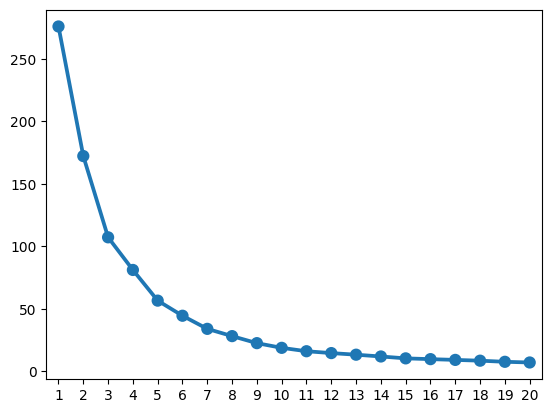

In [17]:
sns.pointplot(x=list(sse.keys()), y=list(sse.values()))
plt.show()

In [18]:
km = KMeans(n_clusters=5, random_state=1)
km.fit(data_normalized)
label = km.labels_
newdata = data.assign(Cluster=label)
newdata

c:\Python\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


,Recency,Frequency,MonetaryValue,Cluster
CUSTOMERNAME,,,,
"AV Stores, Co.",196,51,157807.81,3
Alpha Cognac,65,20,70488.44,0
Amica Models & Co.,265,26,94117.26,0
"Anna's Decorations, Ltd",84,46,153996.13,3
Atelier graphique,188,7,24179.96,2
...,...,...,...,...
"Vida Sport, Ltd",275,31,117713.56,3
Vitachrome Inc.,208,25,88041.26,0
"Volvo Model Replicas, Co",194,19,75754.88,0
